In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset
import pandas as pd

import torch.nn.functional as F
from typing import List, Literal
import math, os
import matplotlib.pyplot as plt
from Transformer.transformer_model import TransformerAttention, DatasetFromCsvFile, evaluate

In [4]:
ROOT_DIR = os.path.dirname(os.path.abspath(""))
assert ROOT_DIR.endswith("Synthesis-Project-1"),\
	"Root directory is not Synthesis-Project-1. Ensure your python file is in the 'src/' directory of the repository"

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerAttention(dim=200, depth=2, heads=4, mlp_dim=512, max_sequence_length=310, local_window_size=5, device=device).to(device)
model.load_state_dict(torch.load(ROOT_DIR + "/models/Transformer/transformer_model.pt"))
model.eval()

TransformerAttention(
  (codiascii_to_embedding): Linear(in_features=1, out_features=200, bias=True)
  (multi_scale_attention_layers): ModuleList(
    (0-1): 2 x MultiScaleAttention(
      (local_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
      )
      (global_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
      )
      (ffn): Sequential(
        (0): Linear(in_features=200, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=200, bias=True)
      )
      (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (regression_head): Sequential(
    (0): Linear(in_features=200, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): 

In [ ]:
max_sequence_length_dataset = 150
batch_size = 512
test_filename = 'test.csv'
train_dataset = DatasetFromCsvFile(test_filename, max_sequence_length_dataset)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

In [55]:
targets, outputs, link = evaluate(model, train_data_loader, [], device)

100%|██████████| 158/158 [03:04<00:00,  1.17s/it]


In [56]:
targets[:10], outputs[:10]

(array([1. , 1. , 0.5, 1. , 1. , 1. , 0.7, 1. , 0.7, 1. ], dtype=float32),
 array([0.99837273, 0.99440515, 0.50958776, 0.98977005, 0.9921577 ,
        0.9860771 , 0.61765796, 0.9243959 , 0.6277614 , 0.99608225],
       dtype=float32))

In [57]:
len(np.where(targets == 1)[0]), len(targets)

(39903, 80851)

In [58]:
# check where targets is 1 and outputs is close to 0
here = np.where((targets == 1) & (outputs < 0.6))
len(outputs[here])

252

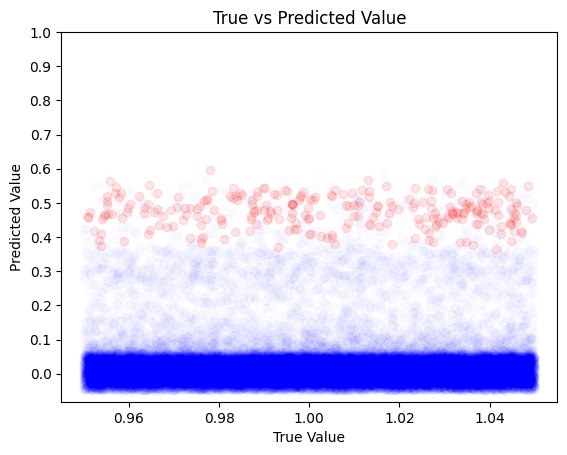

In [59]:
import numpy as np

# Define the amount of jitter
jitter_amount = 0.05

# Add jitter to the data
jitter_targets_1 = targets[targets==1] + np.random.uniform(-jitter_amount, jitter_amount, size=len(targets[targets==1]))
jitter_outputs_1 = outputs[targets==1] + np.random.uniform(-jitter_amount, jitter_amount, size=len(outputs[targets==1]))

jitter_targets_here = targets[here] + np.random.uniform(-jitter_amount, jitter_amount, size=len(targets[here]))
jitter_outputs_here = outputs[here] + np.random.uniform(-jitter_amount, jitter_amount, size=len(outputs[here]))

# Plot the data with jitter
plt.scatter(jitter_targets_1, 1-jitter_outputs_1, alpha=0.01, color='blue')
plt.scatter(jitter_targets_here, 1-jitter_outputs_here, alpha=0.1, color='red')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title('True vs Predicted Value')
plt.show()

In [60]:
here

(array([   79,   320,   900,  1706,  1766,  2423,  2761,  3154,  3459,
         4059,  4068,  4401,  5064,  5255,  5731,  5818,  5819,  6354,
         6440,  6456,  7602,  8622,  9142, 10251, 11480, 11702, 11792,
        12162, 12319, 12358, 13237, 13394, 13509, 13686, 14555, 14590,
        15443, 16169, 16963, 17465, 17702, 18479, 18640, 19154, 19311,
        19798, 21088, 21995, 22058, 22174, 22258, 22268, 22589, 23348,
        23781, 23828, 23936, 24260, 24299, 24442, 25315, 25710, 25923,
        26245, 26492, 26897, 26961, 27040, 27402, 27526, 27933, 27987,
        28122, 28223, 28575, 28961, 28977, 29101, 29388, 29495, 29681,
        29930, 30274, 30685, 30773, 30801, 30954, 31105, 31892, 31909,
        31995, 32144, 32569, 32590, 32611, 32629, 32943, 33206, 33406,
        33625, 33656, 33916, 34200, 34327, 35504, 35616, 35666, 35789,
        35808, 35975, 36178, 36328, 36735, 36889, 37447, 37450, 37625,
        37629, 38064, 38228, 39041, 39820, 39858, 40047, 40112, 40142,
      

In [79]:
log_anomalies = train_dataset.data.iloc[here]

pd.set_option('display.max_colwidth', None)

log_csv = pd.read_csv('test.csv')
print(log_csv.columns)
log_csv.loc[log_anomalies.index, ['URL']].head(252)
# write this in a csv file
log_csv.loc[log_anomalies.index, ['URL']].to_csv('anomalies.csv', index=False)


Index(['URL', 'status', 'bytess', 'user_agent', 'level', 'petition__',
       'petition_CONNECT', 'petition_GET', 'petition_HEAD', 'petition_OPTIONS',
       'petition_POST', 'petition_USER', 'petition_PUT'],
      dtype='object')
